In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

from IPython.display import Image

### recursive generated data & model collapse 

- nature cover: AI models collapse when trained on recursively generated data
    - https://www.nature.com/articles/s41586-024-07566-y
    - The Curse of Recursion: Training on Generated Data Makes Models Forget
        - https://arxiv.org/abs/2305.17493
- Model Collapse refers to a degenerative learning process where models start forgetting **improbable events** over time, as the model becomes poisoned with its own projection of reality.
    - forgetting **improbable events**
    - ppl 的图：更长的尾部。后期代的模型开始生成原始模型永远不会生成的样本；
- 关注下实验设计
    - 控制变量：no data preserved vs. 10% data preserved
    - metrics：PPL
- 不自知地会去利用这样的数据，因为现实的互联网数据已大量地混入 aigc 的数据，真假难辨，尤其是2023年3月，GPT4 发布之后；

In [3]:
Image(url='https://weaviate.io/assets/images/img-d6b8b9c20426e5c2114a25fc4ca60214.jpeg', width=500)

In [12]:
# lose the ability to preceive the full range of the original data distribution
Image(url='./imgs/model_collapsse.png', width=400)

### 3 sources of error

In [13]:
# compound
Image(url='./imgs/3_errors.png', width=500)

### theoretical intuition

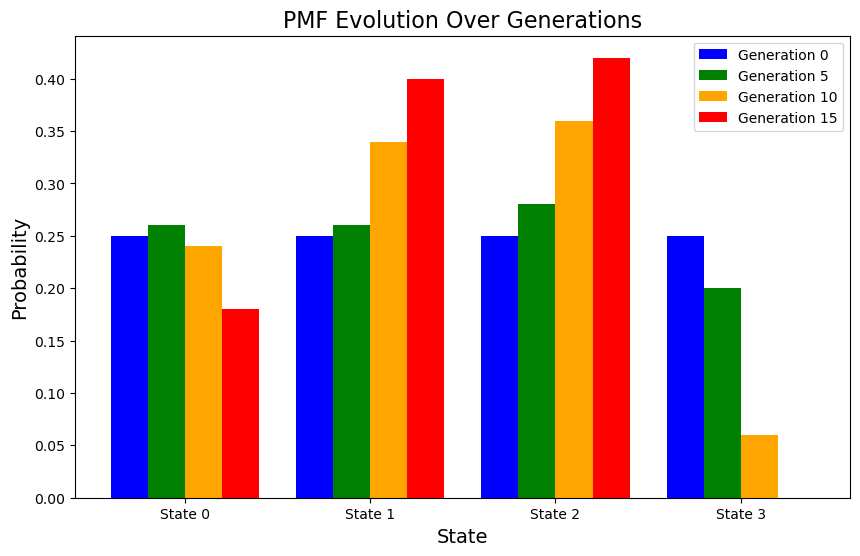

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 定义状态数量和每代的样本数
N = 4      # 状态数量
M = 50     # 每代的样本数
generations = 20  # 总共的代数

# 初始化为近似均匀分布
current_distribution = np.ones(N) / N

# 记录指定代数的分布
selected_generations = [0, 5, 10, 15]
distributions = {gen: None for gen in selected_generations}
distributions[0] = current_distribution.copy()

for gen in range(1, generations + 1):
    # 从当前分布中抽样
    samples = np.random.choice(N, size=M, p=current_distribution)
    
    # 计算新的分布（频率）
    new_distribution = np.zeros(N)
    unique, counts = np.unique(samples, return_counts=True)
    new_distribution[unique] = counts / M
    
    # 更新当前分布
    current_distribution = new_distribution
    
    # 如果是选定的代数，记录分布
    if gen in selected_generations:
        distributions[gen] = current_distribution.copy()
    
    # 检查是否只剩下一个状态（模型坍塌）
    if np.count_nonzero(current_distribution) == 1:
        print(f"Model collapsed at generation {gen}.")
        # 填充剩余代数的分布
        for future_gen in selected_generations:
            if future_gen > gen and distributions[future_gen] is None:
                distributions[future_gen] = current_distribution.copy()
        break

# 绘制指定代数的pmf
colors = ['blue', 'green', 'orange', 'red']
labels = [f"Generation {gen}" for gen in selected_generations]

x = np.arange(N)  # 状态的索引

plt.figure(figsize=(10, 6))

for idx, gen in enumerate(selected_generations):
    if distributions[gen] is not None:
        plt.bar(x + idx*0.2, distributions[gen], width=0.2, color=colors[idx], label=labels[idx])

plt.xlabel("State", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.title("PMF Evolution Over Generations", fontsize=16)
plt.xticks(x + 0.3, [f"State {i}" for i in x])
plt.legend()
plt.show()

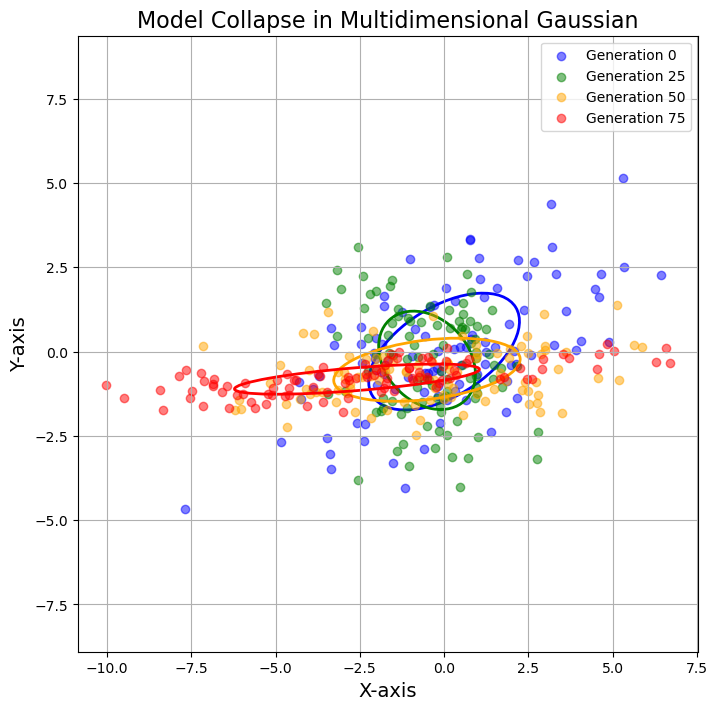

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# 设置随机种子以保证结果可重复
np.random.seed(42)

# 定义初始均值和协方差矩阵
mean = np.array([0, 0])
cov = np.array([[5, 2], [2, 3]])

# 定义每代的样本数和总代数
M = 100    # 每代样本数
generations = 100  # 总共的代数

# 记录每一代的均值和协方差矩阵
means = [mean]
covariances = [cov]

for gen in range(1, generations + 1):
    # 从当前分布中抽样
    samples = np.random.multivariate_normal(mean, cov, size=M)
    
    # 计算新的均值和协方差矩阵（无偏估计）
    new_mean = np.mean(samples, axis=0)
    new_cov = np.cov(samples, rowvar=False, bias=False)
    
    # 更新均值和协方差矩阵
    mean = new_mean
    cov = new_cov
    
    # 记录
    means.append(mean)
    covariances.append(cov)

# 选择要绘制的代数
selected_generations = [0, 25, 50, 75]

# 定义颜色
colors = ['blue', 'green', 'orange', 'red']
labels = [f"Generation {gen}" for gen in selected_generations]

# 绘制散点图
plt.figure(figsize=(8, 8))

for idx, gen in enumerate(selected_generations):
    if gen <= generations:
        # 从记录中获取均值和协方差矩阵
        mean = means[gen]
        cov = covariances[gen]
        
        # 从当前分布中抽样用于可视化
        samples = np.random.multivariate_normal(mean, cov, size=M)
        
        # 绘制散点图
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, color=colors[idx], label=labels[idx])
        
        # 绘制协方差椭圆
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellip = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colors[idx], fc='None', lw=2)
        plt.gca().add_artist(ellip)
        
plt.xlabel("X-axis", fontsize=14)
plt.ylabel("Y-axis", fontsize=14)
plt.title("Model Collapse in Multidimensional Gaussian", fontsize=16)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

### metrics: PPL


- Auto-regressive negative log likelihood loss
    $$
    \begin{split}
    &L=-\frac1N\sum_i^N \log P(y_i)\\
    &PPL=\exp\left(-\frac1N\sum_i^N \log P(y_i)\right)\\
    &PPL=\exp(L)
    \end{split}
    $$
    - minimize L == minimize PPL
- For example, if a language model has a PPL of 30, it means that on average the model is as uncertain as if it had to choose between 30 equally probable options for the next word.



In [5]:
# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# 加载数据集
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
texts = dataset['text']

In [7]:
len(texts)

4358

In [8]:
# 定义困惑度计算函数
def calculate_perplexity(model, tokenizer, text):
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss.item()
    ppl = torch.exp(torch.tensor(loss)).item()
    return ppl

In [9]:
# 加载 GPT-2 模型和分词器
model_name_1 = 'gpt2'
tokenizer_1 = GPT2TokenizerFast.from_pretrained(model_name_1)
model_1 = GPT2LMHeadModel.from_pretrained(model_name_1).to(device)
model_1.eval()

# 加载 GPT-2-XL 模型和分词器
model_name_2 = 'gpt2-xl'
tokenizer_2 = GPT2TokenizerFast.from_pretrained(model_name_2)
model_2 = GPT2LMHeadModel.from_pretrained(model_name_2).to(device)
model_2.eval()

# 计算困惑度
num_samples = 500  # 样本数量，可以根据计算资源调整
sample_length = 100  # 每个样本的最大字符长度

ppl_values_1 = []
ppl_values_2 = []

for i in range(num_samples):
    text = texts[i]
    if len(text.strip()) == 0:
        continue
    text = text.strip()[:sample_length]

    # 计算 GPT-2 的困惑度
    ppl_1 = calculate_perplexity(model_1, tokenizer_1, text)
    # 计算 GPT-2-XL 的困惑度
    ppl_2 = calculate_perplexity(model_2, tokenizer_2, text)

    # 过滤异常值
    if 1 < ppl_1 < 1e4 and 1 < ppl_2 < 1e4:
        ppl_values_1.append(ppl_1)
        ppl_values_2.append(ppl_2)

# 对困惑度取对数
log_ppl_values_1 = np.log(ppl_values_1)
log_ppl_values_2 = np.log(ppl_values_2)

/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


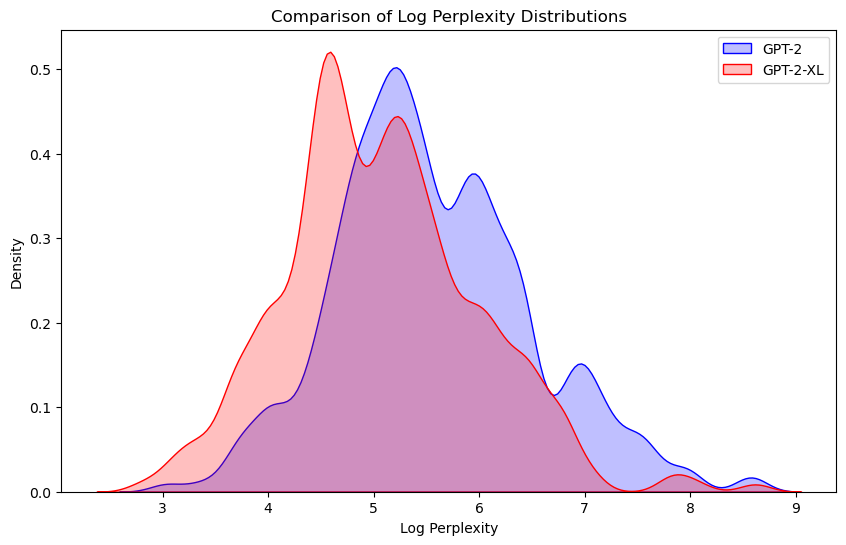

In [10]:
# 绘制困惑度分布的核密度估计图
plt.figure(figsize=(10, 6))

sns.kdeplot(log_ppl_values_1, fill=True, bw_adjust=0.5, color='blue', label='GPT-2')
sns.kdeplot(log_ppl_values_2, fill=True, bw_adjust=0.5, color='red', label='GPT-2-XL')

plt.xlabel('Log Perplexity')
plt.ylabel('Density')
plt.title('Comparison of Log Perplexity Distributions')
plt.legend()
plt.show()